In [1]:
import os
import cv2
import torch
import pandas as pd
from glob import glob
from tqdm import tqdm


CONFIG = {
    "IMG_SIZE": 256,
    "BATCH_SIZE": 64,
    "LR": 1e-4,
    "EPOCHS": 25,
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu",
    "NUM_WORKERS": 16
}

BASE = "/media/behzadhassan/datasets/Defacto/"

DATASETS = {
    "splicing": BASE + "defacto-splicing/",
    "copymove": BASE + "defacto-copymove/",
    "inpainting": BASE + "defacto-inpainting/",
    "face": BASE + "defacto-face/"
}


In [2]:
import pandas as pd

# Load segmentation dataframe
df = pd.read_pickle("defacto_segmentation.pkl")

print("Loaded segmentation dataframe!")
print("Total samples:", len(df))
df.head()


Loaded segmentation dataframe!
Total samples: 229187


,image_path,mask_path,type
0,/media/behzadhassan/datasets/Defacto/defacto-s...,/media/behzadhassan/datasets/Defacto/defacto-s...,splicing
1,/media/behzadhassan/datasets/Defacto/defacto-s...,/media/behzadhassan/datasets/Defacto/defacto-s...,splicing
2,/media/behzadhassan/datasets/Defacto/defacto-s...,/media/behzadhassan/datasets/Defacto/defacto-s...,splicing
3,/media/behzadhassan/datasets/Defacto/defacto-s...,/media/behzadhassan/datasets/Defacto/defacto-s...,splicing
4,/media/behzadhassan/datasets/Defacto/defacto-s...,/media/behzadhassan/datasets/Defacto/defacto-s...,splicing


In [3]:
# ==========================================
# 📌 CELL 3 — Segmentation Dataset Class
# ==========================================

import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

class DeFactoSegDataset(Dataset):
    def __init__(self, df, img_size=256, augment=True):
        self.df = df
        self.img_size = img_size
        self.augment = augment
        self.transform = self.get_transforms()
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load image
        img = cv2.imread(row["image_path"])
        if img is None:
            import tifffile
            img = tifffile.imread(row["image_path"])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Load mask (grayscale)
        mask = cv2.imread(row["mask_path"], cv2.IMREAD_GRAYSCALE)

        # Convert mask to binary (0 or 1)
        mask = (mask > 0).astype(np.float32)

        # Apply transformations
        augmented = self.transform(image=img, mask=mask)
        img = augmented["image"]
        mask = augmented["mask"].unsqueeze(0)   # shape: [1, H, W]

        return img, mask

    def get_transforms(self):
        if self.augment:
            return A.Compose([
                A.Resize(self.img_size, self.img_size),
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.3),
                A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.3),
                
                A.Normalize(
                    mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)
                ),
                ToTensorV2()
            ])
        else:
            return A.Compose([
                A.Resize(self.img_size, self.img_size),
                A.Normalize(
                    mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)
                ),
                ToTensorV2()
            ])


In [4]:
# ==========================================
# 📌 CELL 4 — DeepLabV3+ Model (ResNet-50)
# ==========================================

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models.segmentation import deeplabv3_resnet50

DEVICE = CONFIG["DEVICE"]  # cuda or cpu

def create_deeplabv3(num_classes=1):
    # Load pretrained DeepLabV3 with ResNet-50
    model = deeplabv3_resnet50(weights="DEFAULT")
    
    # Replace classifier for 1-channel output
    model.classifier[-1] = nn.Conv2d(256, num_classes, kernel_size=1)

    return model

# Create model
model = create_deeplabv3()
model = model.to(DEVICE)

# ----- MULTI-GPU -----
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs with DataParallel")
    model = nn.DataParallel(model)

# ----- LOSS: BCE With Logits (best for binary mask) -----
criterion = nn.BCEWithLogitsLoss()

# ----- OPTIMIZER -----
optimizer = optim.Adam(model.parameters(), lr=1e-4)

print("✅ DeepLabV3+ model ready!")


Using 2 GPUs with DataParallel
✅ DeepLabV3+ model ready!


In [4]:
# =====================================
# 📌 CELL 4 — Split + Dataloaders (Segmentation)
# =====================================

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# -----------------------------
# Train / Val Split
# -----------------------------
train_df, val_df = train_test_split(
    df,
    test_size=0.1,
    shuffle=True,
    random_state=42
)

# -----------------------------
# Create Dataset Objects
# -----------------------------
train_dataset = DeFactoSegDataset(train_df, img_size=CONFIG["IMG_SIZE"], augment=True)
val_dataset   = DeFactoSegDataset(val_df,   img_size=CONFIG["IMG_SIZE"], augment=False)

# -----------------------------
# DataLoaders
# -----------------------------
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG["BATCH_SIZE"],
    shuffle=True,
    num_workers=CONFIG["NUM_WORKERS"],
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG["BATCH_SIZE"],
    shuffle=False,
    num_workers=CONFIG["NUM_WORKERS"],
    pin_memory=True
)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))


Train batches: 3223
Val batches: 359


/home/behzadhassan/anaconda3/envs/dl/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/home/behzadhassan/anaconda3/envs/dl/lib/python3.10/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
# =====================================
# 📌 CELL 6 — Training Loop (Segmentation)
# =====================================

import torch
from torch.cuda.amp import GradScaler, autocast
import torch.nn.functional as F
from tqdm import tqdm

scaler = GradScaler()

def dice_loss(pred, target, eps=1e-6):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() + eps
    return 1 - (2 * intersection / union)

for epoch in range(CONFIG["EPOCHS"]):
    model.train()
    train_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['EPOCHS']}")

    for imgs, masks in pbar:
        imgs  = imgs.to(CONFIG["DEVICE"])
        masks = masks.to(CONFIG["DEVICE"])

        optimizer.zero_grad()

        with autocast():  # Mixed precision
            outputs = model(imgs)["out"]   # DeepLab returns dict → use ["out"]

            # BCE loss
            bce = F.binary_cross_entropy_with_logits(outputs, masks)

            # Dice loss (improves mask quality)
            dice = dice_loss(outputs, masks)

            loss = bce + dice

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        pbar.set_postfix({"loss": loss.item()})

    print(f"Train Loss: {train_loss / len(train_loader):.4f}")

    # ----------------------
    # VALIDATION
    # ----------------------
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs  = imgs.to(CONFIG["DEVICE"])
            masks = masks.to(CONFIG["DEVICE"])

            with autocast():
                outputs = model(imgs)["out"]

                bce = F.binary_cross_entropy_with_logits(outputs, masks)
                dice = dice_loss(outputs, masks)
                loss = bce + dice

            val_loss += loss.item()

    print(f"Validation Loss: {val_loss / len(val_loader):.4f}")
    print("-" * 60)

/tmp/ipykernel_2497380/3093646571.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/home/behzadhassan/anaconda3/envs/dl/lib/python3.10/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipykernel_2497380/3093646571.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
Epoch 1/25: 100%|████████████████| 3223/3223 [25:25<00:00,  2.11it/s, loss=0.28]

Train Loss: 0.2452



/tmp/ipykernel_2497380/3093646571.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.1570
------------------------------------------------------------


Epoch 2/25: 100%|███████████████| 3223/3223 [25:33<00:00,  2.10it/s, loss=0.186]

Train Loss: 0.1440


Validation Loss: 0.1286
------------------------------------------------------------


Epoch 3/25: 100%|███████████████| 3223/3223 [25:10<00:00,  2.13it/s, loss=0.142]

Train Loss: 0.1265


Validation Loss: 0.1162
------------------------------------------------------------


Epoch 4/25: 100%|███████████████| 3223/3223 [25:12<00:00,  2.13it/s, loss=0.085]

Train Loss: 0.1158


Validation Loss: 0.1075
------------------------------------------------------------


Epoch 5/25: 100%|███████████████| 3223/3223 [25:15<00:00,  2.13it/s, loss=0.113]

Train Loss: 0.1071


Validation Loss: 0.1053
------------------------------------------------------------


Epoch 6/25: 100%|███████████████| 3223/3223 [25:12<00:00,  2.13it/s, loss=0.083]

Train Loss: 0.1002


Validation Loss: 0.0995
------------------------------------------------------------


Epoch 7/25: 100%|███████████████| 3223/3223 [25:13<00:00,  2.13it/s, loss=0.114]

Train Loss: 0.0953


Validation Loss: 0.0937
------------------------------------------------------------


Epoch 8/25: 100%|██████████████| 3223/3223 [25:09<00:00,  2.14it/s, loss=0.0706]

Train Loss: 0.0915


Validation Loss: 0.0930
------------------------------------------------------------


Epoch 9/25: 100%|██████████████| 3223/3223 [25:52<00:00,  2.08it/s, loss=0.0781]

Train Loss: 0.0870


Validation Loss: 0.0878
------------------------------------------------------------


Epoch 10/25: 100%|█████████████| 3223/3223 [25:35<00:00,  2.10it/s, loss=0.0698]

Train Loss: 0.0835


Validation Loss: 0.0844
------------------------------------------------------------


Epoch 11/25: 100%|█████████████| 3223/3223 [25:31<00:00,  2.10it/s, loss=0.0888]

Train Loss: 0.0803


Validation Loss: 0.0861
------------------------------------------------------------


Epoch 12/25: 100%|██████████████| 3223/3223 [25:52<00:00,  2.08it/s, loss=0.069]

Train Loss: 0.0784


Validation Loss: 0.0818
------------------------------------------------------------


Epoch 13/25: 100%|██████████████| 3223/3223 [25:46<00:00,  2.08it/s, loss=0.105]

Train Loss: 0.0755


Validation Loss: 0.0793
------------------------------------------------------------


Epoch 14/25: 100%|█████████████| 3223/3223 [25:45<00:00,  2.09it/s, loss=0.0783]

Train Loss: 0.0738


Validation Loss: 0.0788
------------------------------------------------------------


Epoch 15/25: 100%|█████████████| 3223/3223 [25:44<00:00,  2.09it/s, loss=0.0892]

Train Loss: 0.0724


Validation Loss: 0.0782
------------------------------------------------------------


Epoch 16/25: 100%|█████████████| 3223/3223 [25:31<00:00,  2.10it/s, loss=0.0869]

Train Loss: 0.0707


Validation Loss: 0.0763
------------------------------------------------------------


Epoch 17/25:  55%|███████      | 1766/3223 [14:06<11:38,  2.09it/s, loss=0.0667]


KeyboardInterrupt: 

In [7]:
torch.save(model.state_dict(), "best_deeplabv3_defacto.pth")
print("Model saved!")

Model saved!


In [7]:
# ======================================
# 📌 DeepLabV3+ with ResNet-50 Backbone
# ======================================

import torch
import torch.nn as nn
from torchvision import models

def create_deeplabv3_resnet50(num_classes=1):
    # Load pretrained DeepLabV3+ (ResNet-50 backbone)
    model = models.segmentation.deeplabv3_resnet50(
        weights=models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT
    )

    # Replace classifier to output 1 channel (binary mask)
    model.classifier[-1] = nn.Conv2d(256, num_classes, kernel_size=1)

    return model


In [29]:
# ==========================================
# 📌 SEGMENTATION PREDICTION (DeepLabV3+)
# ==========================================
import torch
import cv2
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt

# ---------------------------
# Load Saved DeepLab Model
# ---------------------------
def load_deeplab(weights_path):
    model = create_deeplabv3_resnet50()  # SAME function used during training
    checkpoint = torch.load(weights_path, map_location="cpu")

    # Remove 'module.' prefix if DataParallel was used
    clean_state = {}
    for k, v in checkpoint.items():
        clean_state[k.replace("module.", "")] = v

    model.load_state_dict(clean_state)
    model = model.to(CONFIG["DEVICE"])
    model.eval()
    return model


model = load_deeplab("best_deeplabv3_defacto.pth")   # put your checkpoint here
print("Model loaded successfully!")


# ---------------------------
# Preprocessing function
# ---------------------------
val_transform = A.Compose([
    A.Resize(CONFIG["IMG_SIZE"], CONFIG["IMG_SIZE"]),
    A.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    ),
    ToTensorV2()
])


# ---------------------------
# Prediction Function
# ---------------------------
def predict_mask(image_path):
    # Load Image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Apply transforms
    augmented = val_transform(image=img)
    tensor = augmented["image"].unsqueeze(0).to(CONFIG["DEVICE"])

    # Forward pass
    with torch.no_grad():
        output = model(tensor)["out"]   # DeepLabV3+ output
        prob = torch.sigmoid(output)    # convert logits → probabilities
        mask = (prob > 0.5).float()     # threshold for binary mask

    # Convert to numpy
    mask_np = mask.squeeze().cpu().numpy()  # shape: (H, W)
    return img, mask_np


# ---------------------------
# Visualize Output
# ---------------------------
def show_result_light(img, mask):
    # Resize mask to match original image size
    original_h, original_w = img.shape[:2]
    mask_resized = cv2.resize(mask.astype(np.uint8), (original_w, original_h), interpolation=cv2.INTER_NEAREST)

    plt.figure(figsize=(10, 5))

    # ---- 1) MASK (resized) ----
    plt.subplot(1, 2, 1)
    plt.imshow(mask_resized, cmap="gray")
    plt.title("Predicted Mask (Resized)")
    plt.axis("off")

    # ---- 2) LIGHT TRANSPARENT OVERLAY ----
    alpha = 0.4
    color = np.array([0, 255, 0])  # light green

    overlay = img.copy()
    overlay_mask = (mask_resized == 1)

    # Apply overlay safely
    overlay[overlay_mask] = (
        overlay[overlay_mask] * (1 - alpha) + color * alpha
    ).astype(np.uint8)

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Overlay (Light Color)")
    plt.axis("off")

    plt.show()



Model loaded successfully!


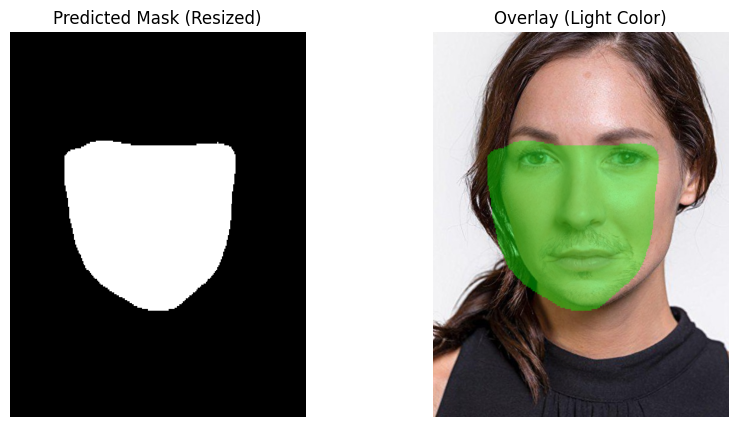

In [38]:
img, mask = predict_mask("/home/behzadhassan/DL/Defacto/3/1.tif")
show_result_light(img, mask)


In [19]:
# ==========================================
# 📌 Evaluate Trained Segmentation Model
# ==========================================
import torch
from tqdm import tqdm
import torch.nn.functional as F

# ---------- Metrics ----------
def dice_coef(pred, target, eps=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) + eps
    return (2 * intersection / union).mean().item()

def iou_score(pred, target, eps=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) - intersection + eps
    return (intersection / union).mean().item()

def pixel_accuracy(pred, target):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    correct = (pred == target).float().sum()
    total = torch.numel(pred)
    return (correct / total).item()


# ---------- Load model again (important after reload) ----------
model = create_deeplabv3_resnet50()
checkpoint = torch.load("best_deeplabv3_defacto.pth", map_location="cpu")

# Remove DataParallel prefixes if needed
clean_state = {}
for k, v in checkpoint.items():
    clean_state[k.replace("module.", "")] = v
model.load_state_dict(clean_state)

model = model.to(CONFIG["DEVICE"])
model.eval()

print("Model loaded. Starting evaluation...")

# ---------- Evaluation Loop ----------
dice_list = []
iou_list = []
acc_list = []

with torch.no_grad():
    for imgs, masks in tqdm(val_loader):
        imgs  = imgs.to(CONFIG["DEVICE"])
        masks = masks.to(CONFIG["DEVICE"])

        outputs = model(imgs)["out"]

        # collect metrics
        dice_list.append(dice_coef(outputs, masks))
        iou_list.append(iou_score(outputs, masks))
        acc_list.append(pixel_accuracy(outputs, masks))

# ---------- Final Metrics ----------
mean_dice = sum(dice_list) / len(dice_list)
mean_iou  = sum(iou_list)  / len(iou_list)
mean_acc  = sum(acc_list)  / len(acc_list)

print("\n===============================")
print(" Segmentation Evaluation Results")
print("===============================")
print(f"Dice Coefficient : {mean_dice:.4f}")
print(f"IoU Score        : {mean_iou:.4f}")
print(f"Pixel Accuracy   : {mean_acc:.4f}")
print("===============================\n")


Model loaded. Starting evaluation...


/home/behzadhassan/anaconda3/envs/dl/lib/python3.10/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|█████████████████████████████████████████| 359/359 [04:16<00:00,  1.40it/s]


 Segmentation Evaluation Results
Dice Coefficient : 0.6640
IoU Score        : 0.6153
Pixel Accuracy   : 0.9925

